# Computing Lyapunov Family Through Differential Correction and Continuation
In this notebook, we'll learn how to use differential correction to compute a Lyapunov Orbit. Then we'll use continuation techniques to compute an entire family


In [2]:
@time using ThreeBodyProblem
@time using OrdinaryDiffEq
@time using LinearAlgebra
@time using Plots

  0.000070 seconds (98 allocations: 7.672 KiB)
  0.000039 seconds (98 allocations: 7.656 KiB)
  0.000036 seconds (98 allocations: 7.656 KiB)
  0.000037 seconds (98 allocations: 7.656 KiB)


## Lyapunov Orbits
Lyapunov orbits are planar periodic orbits that are centered around the Lagrange points, normally L1 and L2. There is a continuous family of Lyapunov orbits in the CR3BP, each one with a unique parameterization in Jacobi constant and period. We're going to compute a family of Lyapunov Orbits in the Earth/Moon system centered around L2.

In [3]:
sys = earth_moon() # create a CR3BP system of the Earth-Moon system
Lpts = computeLpts(sys) # compute the L1, L2, L3, L4, and L5 Lagrange points

5-element Vector{Vector{Float64}}:
 [0.8369171147702252, 0.0, 0.0]
 [1.1556806107537716, 0.0, 0.0]
 [-1.0050624773946386, 0.0, 0.0]
 [0.4878498186114851, 0.8660254037844386, 0.0]
 [0.4878498186114851, -0.8660254037844386, 0.0]

### Compute the Jacobian Matrix of the CR3BP dynamics at L2

In [4]:
rv₂ = [Lpts[2];zeros(3)] # initial state vector at L2
F = CR3BPjac(rv₂, sys) # compute the Jacobian of the CR3BP at the initial state vector
Λ, V = eig(F) # compute the eigenvalues and eigenvectors of the Jacobian (sorted by magnitude of eigenvalue imaginary part)

(ComplexF64[-2.15867800085904 + 0.0im, 2.158678000859039 + 0.0im, 0.0 - 1.7861783448596829im, 0.0 + 1.7861783448596829im, 0.0 - 1.8626480160639864im, 0.0 + 1.8626480160639864im], ComplexF64[0.35560354350490014 + 0.0im -0.3556035435049 + 0.0im … -0.1536007350100866 - 1.0680387387198203e-17im -0.1536007350100866 + 1.0680387387198203e-17im; 0.2241159892020757 + 0.0im 0.2241159892020757 + 0.0im … -1.9840615187086835e-16 + 0.44737859623170123im -1.9840615187086835e-16 - 0.44737859623170123im; … ; -0.48379425553128286 + 0.0im 0.48379425553128275 + 0.0im … 0.8333088547004689 - 0.0im 0.8333088547004689 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … -0.0 - 0.0im 0.0 + 0.0im])

Let's plot the eigenvalues.

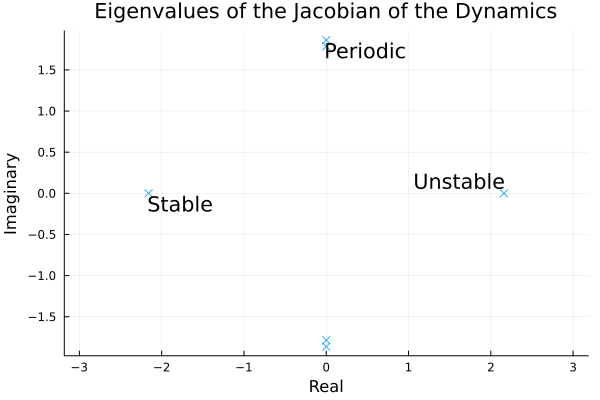

In [9]:
plot_eig = scatter(real(Λ),imag(Λ),legend=false,title="Eigenvalues of the Jacobian of the Dynamics",xaxis="Real",yaxis="Imaginary",aspect_ratio=1,marker=:x);
annotate!(plot_eig, real(Λ[1]), imag(Λ[1]), text("Stable",:top, :left));
annotate!(plot_eig, real(Λ[2]), imag(Λ[2]), text("Unstable",:bottom, :right));
annotate!(plot_eig, real(Λ[6]), imag(Λ[6]), text("Periodic",:top, :left))

There are two eigenvectors on the real axis, one is stable and the other is unstable. The other four eigen vectors are complex conjugates, and the real part of the eigen values are zero. That means they correspond to purely periodic motion. We will see that one corresponds to in-plane motion while the other corresponds to out-of-plane motion motion


In [10]:
V[:,3] # Out of plane

6-element Vector{ComplexF64}:
                0.0 - 0.0im
                0.0 - 0.0im
                0.0 - 0.48850672329828293im
                0.0 - 0.0im
                0.0 - 0.0im
 -0.872560130473754 - 0.0im

All components except z and ż are zero

In [11]:
V[:,5] # In plane

6-element Vector{ComplexF64}:
     -0.1536007350100866 - 1.0680387387198203e-17im
 -1.9840615187086835e-16 + 0.44737859623170123im
                    -0.0 - 0.0im
    8.45650577383339e-17 + 0.2861041043325081im
      0.8333088547004689 - 0.0im
                    -0.0 - 0.0im

z and ż are zero

### Perturb the Lagrange Point in the planar periodic direction
If we perturb the Lagrange Point in the direction of the eigenvector that corresopnds to planar periodic motion, we can approximate the Lyapunov orbit.

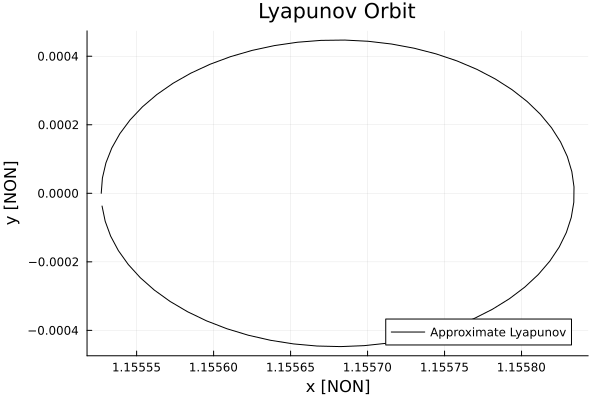

In [12]:
### Let's perturb in the plane to start the family of Lyapunov Orbits
λ = Λ[5] # eigenvalue corresponding to in-plane motion
v = V[:,5] # eigenvector corresponding to in-plane motion
rvs = [rv₂ + α*(real(v)*cos(θ) + imag(v)*sin(θ)) for θ = 0:0.1:2π, α = 1e-3]
p_lyap1 = plot(rvs,planar=true,label="Approximate Lyapunov",title="Lyapunov Orbit",xaxis="x [NON]",yaxis="y [NON]")
# The plot shows a circle that approximates a Lyapunov orbit, but if we integrate any points along the circle, they'll likely diverge

We can approximate the period of the Lyapunov orbit with T = ωₙ/2π, where ωₙ = |λ₅|


In [13]:
ωₙ = abs(λ) # approximate the natural frequency of the Lyapunov orbit
T = 2π/ωₙ # approximate the period of the Lyapunov orbit

3.3732542342899334

### Integrate the perturbed state
Let's see what the approximate Lyapunov Orbit looks like when we actually integrate it in the CR3BP.


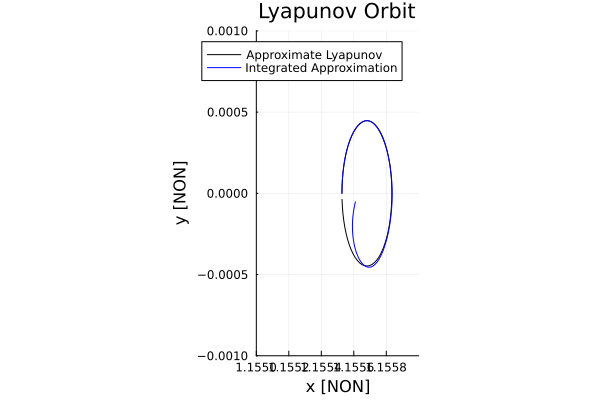

In [14]:
rv₀ = copy(rvs[1]) # initial state vector at the first point in our approximation
tspan = (0,T) # arbitrary timespan
prob_approx = ODEProblem(CR3BPdynamics!,rv₀,tspan,sys) # Let's integrate the first point in our approximation
sol_approx = solve(prob_approx, TsitPap8()) # integrate
plot!(p_lyap1,sol_approx,idxs=(1,2),aspect_ratio=1,linecolor=:blue, xlims=(1.155,1.156),ylims = (-0.001,0.001), label="Integrated Approximation")

You can see that the integrated approximation is not quite a Lyapunov orbit, as it doesn't close on itself. But the intial conditon and period were pretty close.

## Differential Corrector
We can use a differential corrector to find the exact Lyapunov orbit. A differential corrector uses Newton's method to find a zero of a multivariate function. If we have an initial condition vector $\vec{\chi}$ and a constraint vector $\vec{\gamma}$ which we wish to drive to zero, we can compute the small change in $\vec{\chi}$ that minimizes $\vec{\gamma}$ with the equation
\begin{align} 
\delta \vec{\chi} = -\mathbf{J}^{\dagger}\vec{\gamma}.
\end{align}

The we can iteratively update our initial condition guess until convergence
\begin{align}
\vec{\chi}^{(i+1)} = \vec{\chi}^{(i)} + \delta \vec{\chi}.
\end{align}

We can take advantage of a symmetry in the CR3BP. Lyapunov Orbits are symmetric about the XZ plane. That means we can work with half an orbit, which is better behaved numerically. If we can find an orbit segment that crosses $y=0$ perpendicularly, then that segment can be mirrored to create a full periodic orbit.

Therefore, we can constrain our initial guess to lie on the $y=0$ plane and to have a velocity normal to that plane (i.e. $y_0 = \dot{x}_0 = \dot{z}_0 = 0$). That means we can compose our initial condition vector as
\begin{align}
\vec{\chi} = \begin{bmatrix}x_0 \\ z_0 \\ \dot{y}_0 \end{bmatrix}.
\end{align}

The next plane crossing should occur at exactly half the period, $t=T/2$, and should meet the same conditions (i.e. $y = \dot{x} = \dot{z} = 0$). We can use an event function to force $y=0$, so our constraint vector can be simply
\begin{align}
\vec{\gamma} = \begin{bmatrix}0 - \dot{x} \\ 0 - \dot{z}\end{bmatrix}.
\end{align}

### Event function
We create an event function to stop when the integrator crosses the XZ plane

In [20]:
# event function
condition(u, t, integrator) = u[2] # define a function to stop the integrator when y = 0
affect!(integrator) = terminate!(integrator) # define an affect function that defines what happens when the condition is met (integrator stops)
cb = OrdinaryDiffEq.ContinuousCallback(condition, nothing, affect!) # create the callback 
# (the 'nothing' input defines what happens when passing from negative to positive, while the 'affect!' input defines what happens when passing from positive to negative. We could switch these to make the integration stop when passing from neg to pos)

ContinuousCallback{…}(condition, nothing, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, nothing, SciMLBase.LeftRootFind, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0, 1//100)

Once we have converged to the true periodic orbit, this condition will stop the integration after time $T/2$.

We can compute the Jacobian J by considering the total derivative
\begin{align}
    \delta \vec{x}(\vec{x}_0,T/2) &= \frac{\partial \vec{x}}{\partial \vec{x}_0}\delta\vec{x}_0 + \frac{\partial \vec{x}}{\partial t}\delta(T/2).
\end{align}

$\frac{\partial \vec{x}}{\partial \vec{x}_0}$ is the state transition matrix, while $\frac{\partial \vec{x}}{\partial t}$ is simply the output of the equations of motion at time $T/2$.

We can express $\delta(T/2)$ in terms of the coordinates by noting that 
\begin{align}
    \delta y = \frac{\partial y}{\partial \vec{x}_0}\delta\vec{x}_0 + \frac{\partial y}{\partial t}\delta(T/2).
\end{align}

Since our event function will force $y=0$, we can assume $\delta y = 0$ giving us 
\begin{align}
    \delta(T/2) = -\frac{1}{\dot{y}}\frac{\partial y}{\partial \vec{x}_0}\delta\vec{x}_0,
\end{align}
which evaluates to a scalar.

Putting this all together, we can express the Jacobian as
\begin{align}
    \mathbf{J} &= \Phi_{T/2} - \frac{1}{\dot{y}}\frac{\partial \vec{x}}{\partial t}\frac{\partial y}{\partial \vec{x}}
\end{align}

We only pick the rows and columns of the Jacobian matrix that are relevant for our constraints and free variables, giving us the following equation
\begin{align}
    \begin{bmatrix}
    \delta x_0\\
    \delta z_0\\
    \delta\dot{y}_0
    \end{bmatrix} &= \left(\begin{bmatrix}
    \Phi_{4,1} & \Phi_{4,3} & \Phi_{4,5}\\
    \Phi_{6,1} & \Phi_{6,3} & \Phi_{6,5}
    \end{bmatrix} - \frac{1}{\dot{y}}\begin{bmatrix}
    \ddot{x}\\
    \ddot{z}
    \end{bmatrix}
    \begin{bmatrix}
    \Phi_{2,1} & \Phi_{2,3} & \Phi_{2,5}
    \end{bmatrix}\right)^\dagger
    \begin{bmatrix}
    -\dot{x}\\
    -\dot{z}
    \end{bmatrix}
\end{align}

If we wish to hold $x_0$ fixed, we use
\begin{align}
    \begin{bmatrix}
    \delta z_0\\
    \delta\dot{y}_0
    \end{bmatrix} &= \left(\begin{bmatrix}
    \Phi_{4,3} & \Phi_{4,5}\\
    \Phi_{6,3} & \Phi_{6,5}
    \end{bmatrix} - \frac{1}{\dot{y}}\begin{bmatrix}
    \ddot{x}\\
    \ddot{z}
    \end{bmatrix}
    \begin{bmatrix}
    \Phi_{2,3} & \Phi_{2,5}
    \end{bmatrix}\right)^{-1}
    \begin{bmatrix}
    -\dot{x}\\
    -\dot{z}
    \end{bmatrix}.
\end{align}
To hold $z_0$ fixed, we use
\begin{align}
        \begin{bmatrix}
    \delta x_0\\
    \delta\dot{y}_0
    \end{bmatrix} &= \left(\begin{bmatrix}
    \Phi_{4,1} & \Phi_{4,5}\\
    \Phi_{6,1} & \Phi_{6,5}
    \end{bmatrix} - \frac{1}{\dot{y}}\begin{bmatrix}
    \ddot{x}\\
    \ddot{z}
    \end{bmatrix}
    \begin{bmatrix}
    \Phi_{2,1} & \Phi_{2,5}
    \end{bmatrix}\right)^{-1}
    \begin{bmatrix}
    -\dot{x}\\
    -\dot{z}
    \end{bmatrix}.
\end{align}
To hold $\dot{y}_0$ fixed, we use
\begin{align}
    \begin{bmatrix}
    \delta x_0\\
    \delta z_0
    \end{bmatrix} &= \left(\begin{bmatrix}
    \Phi_{4,1} & \Phi_{4,3}\\
    \Phi_{6,1} & \Phi_{6,3}
    \end{bmatrix} - \frac{1}{\dot{y}}\begin{bmatrix}
    \ddot{x}\\
    \ddot{z}
    \end{bmatrix}
    \begin{bmatrix}
    \Phi_{2,1} & \Phi_{2,3}
    \end{bmatrix}\right)^{-1}
    \begin{bmatrix}
    -\dot{x}\\
    -\dot{z}
    \end{bmatrix}.
\end{align}

### State Transition Matrix
The differential corrector will need to use the State Transition Matrix (STM), which we can compute with the CR3BPstm function. The STM is defined as the variation of the final conditions with respect to the initial conditions
\begin{align}
\mathbf{\Phi}(t_f,t_0)=\frac{\partial \vec{x}(t_f)}{\partial \vec{x}(t_0)}.
\end{align}

We can integrate the STM along with the state by using the variational equations.
\begin{align}
    \dot{\mathbf{\Phi}} = \nabla \vec{f}(\vec{x}(t))\mathbf{\Phi}(t,0)
\end{align}

We just reshape the STM as a vector and concatenate it to the state. 

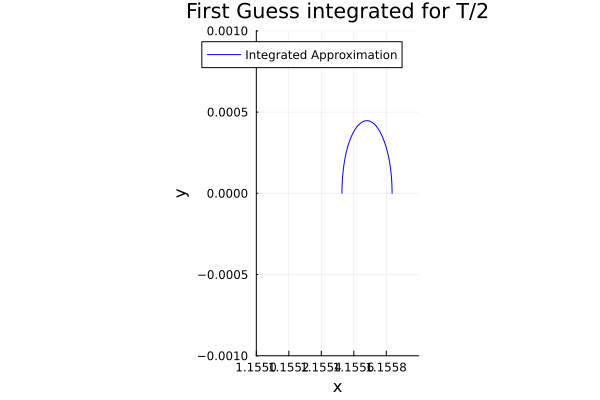

In [23]:
Φ₀ = I(6) # intial STM
w₀ = vcat(rv₀, reshape(Φ₀,36,1)) # initial state and STM concatenated into a vector
prob_stm = ODEProblem(CR3BPstm!,w₀,tspan,sys) # create the ODE problem
sol_stm = solve(prob_stm, TsitPap8(), callback=cb) # integrate with the callback function
plot(sol_stm,idxs=(1,2),title="First Guess integrated for T/2",xaxis="x",yaxis="y",aspect_ratio=1,linecolor=:blue, xlims=(1.155,1.156),ylims = (-0.001,0.001), label="Integrated Approximation")

Let's pull out the STM from the ODESolution.


In [24]:
w = sol_stm[end] # final state and STM
rv = w[1:6] # final state
Φ = reshape(w[7:42],6,6) # final STM Φ = ∂x/∂x₀

6×6 Matrix{Float64}:
  25.5034   -4.67721   0.0        7.33953   4.88936   0.0
 -15.7931    2.10493   0.0       -4.86415  -2.9127    0.0
   0.0       0.0      -0.989615   0.0       0.0       0.0732917
  54.2047  -10.6404    0.0       15.6914   10.0036    0.0
 -35.9997    6.34955   0.0       -9.97037  -7.638     0.0
   0.0       0.0      -0.233827   0.0       0.0      -0.98651

### Compute change in initial conditions
Let's keep $x_0$ constant.

In [26]:
∂ẋ = 0 - rv[4] # error in ẋ
∂ż = 0 - rv[6] # error in ż

ẋ,ẏ,ż,ẍ,ÿ,z̈ = CR3BPdynamics(rv, sys, 0) # take time derivative of final state

∂Φ = [Φ[4,3] Φ[4,5]; # partial derivatives from the STM
      Φ[6,3] Φ[6,5]]
dyad = [ẍ;z̈]*[Φ[2,3] Φ[2,5]]
∂z, ∂ẏ = (∂Φ - dyad/ẏ)\[∂ẋ; ∂ż] # solve for the perturbations
rv₀[3] += ∂z # perturb the initial state vector
rv₀[5] += ∂ẏ # perturb the initial state vector

3.172156751174848

Now, let's see if our initial conditions return to form a closed orbit

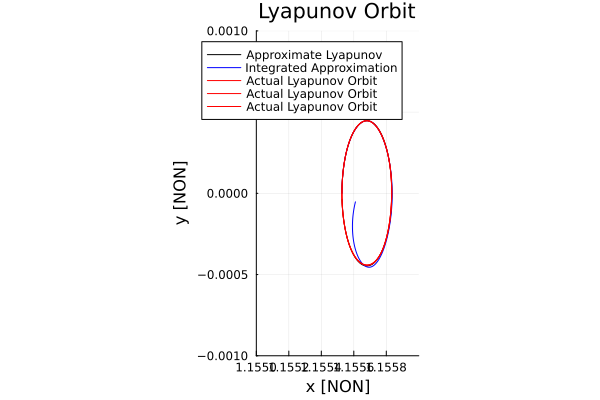

In [27]:
w₀ = vcat(rv₀, reshape(Φ₀,36,1)) # initial state and STM concatenated into a vector
prob_lyap = ODEProblem(CR3BPstm!,w₀,tspan,sys) # Let's integrate our corrected state
sol_lyap = solve(prob_lyap, TsitPap8()) # integrate
plot!(p_lyap1,sol_lyap,idxs=(1,2),aspect_ratio=1,linecolor=:red, xlims=(1.155,1.156),ylims = (-0.001,0.001), label="Actual Lyapunov Orbit")
# Now we can see that the integrated orbit closes on itself, and we have found the 

We now have a closed orbit. We've just computed our first Lyapunov Orbit!

### Let's write this up in a function

In [29]:
"""
   differential_corrector(sys::System, rv₀; myconst=3, iter=100, plot=false, t0=0., tf=1., dir=1, tol=1e-12)

Given a sufficiently close guess at a periodic trajectory rv₀, returns the corrected initial condition and period
"""
function differential_corrector(sys::System, rv₀; myconst=3, iter=100, plot=false, t0=0., tf=1., dir=1, tol=1e-12)
   Φ₀ = I(6)

   tspan = (t0, tf)

   # event function
   condition(u, t, integrator) = u[2]
   affect!(integrator) = terminate!(integrator)
   if dir == 1 # stop when passing through from + to -
    cb = OrdinaryDiffEq.ContinuousCallback(condition, nothing, affect!)
elseif dir == -1 # stop when passing through from - to +
    cb = OrdinaryDiffEq.ContinuousCallback(condition, affect!, nothing)
elseif dir == 0 # stop when passing through either direction
      cb = DiscreteCallback(condition, affect!)
   end

   sol_iters = []

   for k = 1:iter
      w₀ = vcat(rv₀, reshape(Φ₀,36,1))

      prob = ODEProblem(CR3BPstm!,w₀,tspan,sys)
      sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12, callback=cb)
      push!(sol_iters, sol)

      w = sol[end] # final state and STM
      rv = w[1:6] # final state
      Φ = reshape(w[7:42],6,6)
      global T = 2*sol.t[end]

      ∂ẋ = 0 - rv[4]
      ∂ż = 0 - rv[6]
      err = norm([∂ẋ, ∂ż])
      @info("Iter: $k, Differential corrector error: $err")
      if err < tol
         @info("Differential corrector converged")
         break
      end

      if k == iter
         @warn("Iter: $k, Differential corrector did not converge")
      end

      ẋ,ẏ,ż,ẍ,ÿ,z̈ = CR3BPdynamics(rv, sys, 0) # take time derivative of final state

      if myconst == 1
         ∂Φ = [Φ[4,3] Φ[4,5];
               Φ[6,3] Φ[6,5]]
         dyad = [ẍ;z̈]*[Φ[2,3] Φ[2,5]]

         ∂z, ∂ẏ = (∂Φ - dyad/ẏ)\[∂ẋ; ∂ż]
         rv₀[3] += ∂z
         rv₀[5] += ∂ẏ
      elseif myconst == 3
         ∂Φ = [Φ[4,1] Φ[4,5];
               Φ[6,1] Φ[6,5]]
         dyad = [ẍ;z̈]*[Φ[2,1] Φ[2,5]]

         ∂x, ∂ẏ = (∂Φ - dyad/ẏ)\[∂ẋ; ∂ż]
         rv₀[1] += ∂x
         rv₀[5] += ∂ẏ
      elseif myconst == 5
         ∂Φ = [Φ[4,1] Φ[4,3];
               Φ[6,1] Φ[6,3]]
         dyad = [ẍ;z̈]*[Φ[2,1] Φ[2,5]]

         ∂x, ∂z = (∂Φ - dyad/ẏ)\[∂ẋ; ∂ż]
         rv₀[1] += ∂x
         rv₀[3] += ∂z
      else
         error("myconst should be 1, 3, or 5")
      end

   end

   return rv₀, T, sol_iters
end

differential_corrector

## Continuation
We can use our differential corrector to com